# Лабораторная работа №6. Машинное обучение

## 1. Анализ данных и предобработка

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from transformers import BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
data = pd.read_csv('./comments.csv')

In [ ]:
data

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [ ]:
data['toxic'].value_counts()

,count
toxic,
0,143106
1,16186


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


В рамках предобработки сделаем следующее:
1. Приведение текста к нижнему регистру, удаление лишних символов, html-тегов и чисел, чтобы не было накладок при работе с текстом в дальнейшем
2. Лемматизация (для работы с bert не обязательна, но для собственного успокоения и красоты все равно сделаем)
3. Удаление стоп-слов (and, or и так далее). Хотя они тоже не оказывают особого влияния на функционирование именно модели bert, в целом при обработке текста полезно это делать

In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if pd.isnull(text):
        return ""

    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    lemmatized = [token.lemma_ for token in doc if token.text not in stop_words]

    return " ".join(lemmatized)

tqdm.pandas()
data["clean_text"] = data["text"].progress_apply(preprocess_text)

100%|██████████| 159292/159292 [36:49<00:00, 72.10it/s]


## 2. Токенизация и подготовка к обучению

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 128
BATCH_SIZE = 64

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['clean_text'].tolist(),
    data['toxic'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=data['toxic']
)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=MAX_LEN)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=MAX_LEN)

class ToxicCommentsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

train_dataset = ToxicCommentsDataset(train_encodings, train_labels)
val_dataset = ToxicCommentsDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

Векторизацию не делаем, так как она уже встроена в bert

## 3. Обучение и оценка модели

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for batch in tqdm(loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            labels.extend(batch['labels'].cpu().numpy())

    f1 = f1_score(labels, preds)
    return f1

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader)
    val_f1 = evaluate(model, val_loader)

    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation F1: {val_f1:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3


100%|██████████| 1992/1992 [41:19<00:00,  1.24s/it]


Train Loss: 0.1062
Validation F1: 0.8247

Epoch 2/3


100%|██████████| 1992/1992 [41:20<00:00,  1.25s/it]


Train Loss: 0.0707
Validation F1: 0.8292

Epoch 3/3


100%|██████████| 1992/1992 [41:21<00:00,  1.25s/it]


Train Loss: 0.0450
Validation F1: 0.8287


Таким образом, модель уже на первой эпохе обучилась достаточно хорошо. F1 изменяется не сильно, поэтому можно сказать, что оптимальное значение было достигнуто.

Loss стабильно убывает, что свидетельствует о хороших результатах обучения.

Для визуальной оценки точности можно построить матрицу путаницы

<Figure size 600x600 with 0 Axes>

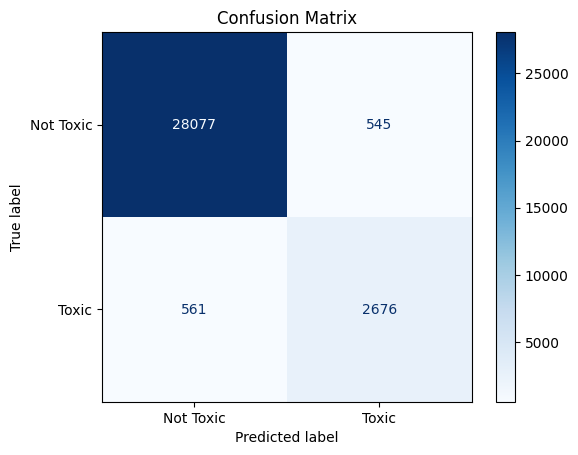

In [ ]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Toxic', 'Toxic'])

plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()